In [1]:
feat_names = ['chamfer','through_hole','triangular_passage','rectangular_passage','6sides_passage',
              'triangular_through_slot','rectangular_through_slot','circular_through_slot',
              'rectangular_through_step','2sides_through_step','slanted_through_step','Oring','blind_hole',
              'triangular_pocket','rectangular_pocket','6sides_pocket','circular_end_pocket',
              'rectangular_blind_slot','v_circular_end_blind_slot','h_circular_end_blind_slot',
              'triangular_blind_step','circular_blind_step','rectangular_blind_step','round','stock']
NUM_CLASSES = len(feat_names)  # 25

Found 9992 usable parts out of 10000.
Train faces: 130911  Val faces: 16498  Test faces: 16530  (D=10)
                           precision    recall  f1-score   support

                  chamfer      0.204     0.436     0.278       156
             through_hole      0.366     0.610     0.458       146
       triangular_passage      0.076     0.135     0.097       490
      rectangular_passage      0.143     0.052     0.076       675
           6sides_passage      0.226     0.426     0.296      1006
  triangular_through_slot      0.087     0.396     0.143       227
 rectangular_through_slot      0.065     0.077     0.071       235
    circular_through_slot      0.141     0.462     0.216        78
 rectangular_through_step      0.108     0.192     0.138       318
      2sides_through_step      0.263     0.299     0.280       481
     slanted_through_step      0.085     0.081     0.083       297
                    Oring      0.786     0.659     0.717       452
               blind_hole

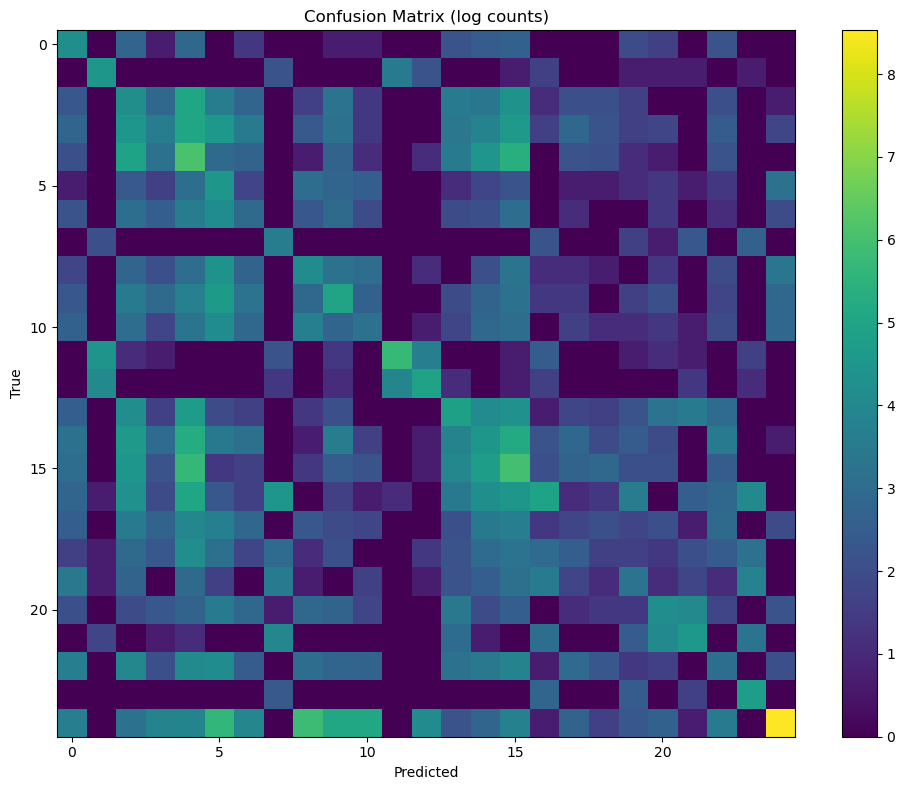

In [2]:
# dataset_loader.py
import json, pickle
from pathlib import Path
import numpy as np
import torch
# splits.py
from pathlib import Path
import random

def get_available_ids(root: Path, max_id=10000, strict=True):
    root = Path(root)
    good = []
    for i in range(max_id):
        pkl = root / f"{i}.pkl"
        js  = root / "labels" / f"{i}.json"
        if not (pkl.exists() and js.exists()):
            continue
        if strict:
            try:
                with open(pkl, "rb") as f: G = pickle.load(f)
                with open(js, "r") as f:  J = json.load(f)
                if int(G["num_nodes"]) != len(J["per_face_labels"]):
                    # optional: print(f"[skip {i}] nodes={int(G['num_nodes'])} labels={len(J['per_face_labels'])}")
                    continue
            except Exception:
                continue
        good.append(i)
    return good

def split_ids(ids, seed=13, frac=(0.8, 0.1, 0.1)):
    rng = np.random.default_rng(seed)
    ids = np.array(ids)
    rng.shuffle(ids)
    n = len(ids)
    n_tr = int(frac[0]*n)
    n_va = int(frac[1]*n)
    train = ids[:n_tr].tolist()
    val   = ids[n_tr:n_tr+n_va].tolist()
    test  = ids[n_tr+n_va:].tolist()
    return train, val, test

def _one_hot(idx, n):
    v = np.zeros(n, dtype=np.float32); v[int(idx)] = 1.0; return v

def build_node_features(face_feats: dict, use_type_onehot=False):
    """
    Returns float32 [num_nodes, D] matrix from face_features dict.
    Included: area, adj(deg), loops, centroid(3), convexity(one-hot 3), (optional) type(one-hot)
    """
    n = len(face_feats['area'])
    area      = np.asarray(face_feats['area'], dtype=np.float32).reshape(n,1)
    deg       = np.asarray(face_feats['adj'], dtype=np.float32).reshape(n,1)
    loops     = np.asarray(face_feats['loops'], dtype=np.float32).reshape(n,1)
    centroid  = np.asarray(face_feats['centroid'], dtype=np.float32)  # [n,3]
    conv      = np.asarray(face_feats['convexity'], dtype=np.int64)
    conv_oh   = np.stack([_one_hot(c, 3) for c in conv], axis=0)      # [n,3]

    parts = [area, deg, loops, centroid, conv_oh]

    if use_type_onehot:
        # surface type id from OCC adaptor; make it one-hot within observed range
        stype = np.asarray(face_feats['type'], dtype=np.int64)
        S = int(stype.max()) + 1
        stype_oh = np.stack([_one_hot(t, S) for t in stype], axis=0)
        parts.append(stype_oh)
    else:
        parts.append(np.asarray(face_feats['type'], dtype=np.float32).reshape(n,1))

    x = np.concatenate(parts, axis=1).astype(np.float32)
    # light normalization (helps)
    x[:,0] = (x[:,0] - x[:,0].mean()) / (x[:,0].std()+1e-6)  # area z-norm
    x[:,3:6] = x[:,3:6] / (np.linalg.norm(x[:,3:6], axis=1, keepdims=True)+1e-6)  # centroid direction-ish
    return x

def load_sample(root: Path, idx: int):
    root = Path(root)
    # Pick the step extension you used
    step_path = (root / f"{idx}.stp")
    if not step_path.exists():
        step_path = root / f"{idx}.step"
    pkl_path  = root / f"{idx}.pkl"
    json_path = root / "labels" / f"{idx}.json"
    if not (pkl_path.exists() and json_path.exists()):
        raise FileNotFoundError(idx, step_path, pkl_path, json_path)

    with open(pkl_path, "rb") as f:
        G = pickle.load(f)
    with open(json_path, "r") as f:
        J = json.load(f)

    num_nodes = int(G['num_nodes'])
    y = np.array(J['per_face_labels'], dtype=np.int64)
    assert len(y) == num_nodes, f"len(labels)={len(y)} != num_nodes={num_nodes} (idx={idx})"

    x = build_node_features(G['face_features'])
    edge_index = np.asarray(G['edge_index'], dtype=np.int64)  # shape [2, E]

    # torch tensors for PyG
    data = {
        "x": torch.from_numpy(x),
        "edge_index": torch.from_numpy(edge_index),
        "y": torch.from_numpy(y),
        "idx": idx
    }
    return data
# baseline_tabular.py
import numpy as np
from pathlib import Path
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

root = Path("./dataset/dataset_generation/data")

avail = get_available_ids(root, max_id=10000)
print(f"Found {len(avail)} usable parts out of 10000.")
if len(avail) < 50:
    raise RuntimeError("Too few usable samples. Generate more or fix failures.")

train_ids, val_ids, test_ids = split_ids(avail, seed=13)

def stack_faces(id_list):
    Xs, ys = [], []
    for i in id_list:
        d = load_sample(root, i)
        Xs.append(d["x"].numpy())
        ys.append(d["y"].numpy())
    return np.concatenate(Xs, axis=0), np.concatenate(ys, axis=0)
# ---- assemble ----
Xtr, ytr = stack_faces(train_ids)
Xva, yva = stack_faces(val_ids)
Xte, yte = stack_faces(test_ids)
print(f"Train faces: {Xtr.shape[0]}  Val faces: {Xva.shape[0]}  Test faces: {Xte.shape[0]}  (D={Xtr.shape[1]})")

# ---- class balance ----
counts = np.bincount(ytr, minlength=NUM_CLASSES)
w = 1.0 / (counts + 1e-6)
w *= (len(w) / w.sum())
sample_weight_tr = w[ytr]

# ---- train ----
clf = HistGradientBoostingClassifier(max_depth=6, learning_rate=0.1, early_stopping=True, validation_fraction=0.1)
clf.fit(Xtr, ytr, sample_weight=sample_weight_tr)

# ---- eval ----
pred = clf.predict(Xte)
print(classification_report(yte, pred, digits=3, target_names=feat_names))

# Confusion matrix (optional)
cm = confusion_matrix(yte, pred, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(10,8))
plt.imshow(np.log1p(cm), aspect='auto')  # log scale to see small counts
plt.title("Confusion Matrix (log counts)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(); plt.tight_layout(); plt.show()

# ---- quick per-part inference helper ----
def predict_part(part_id: int):
    d = load_sample(root, part_id)
    yhat = clf.predict(d["x"].numpy())
    return [feat_names[int(k)] for k in yhat]

# example:
# print(predict_part(test_ids[0])[:10])


In [3]:
# validate_features.py
import pickle, numpy as np
from pathlib import Path

def feature_dim(pkl):
    g = pickle.loads(Path(pkl).read_bytes())
    ff = g["face_features"]
    n = len(ff["area"])
    # scalar features: area(1), deg(1), loops(1), centroid(3), convexity one-hot(3)=9
    base = 1+1+1+3+3
    stype = np.asarray(ff["type"])
    # if you one-hot per-sample (bad), this will vary: stype_dim = stype.max()+1
    # if you use scalar type (good), set stype_dim=1
    stype_dim = 1  # <- set to global dim if you truly one-hot globally
    return base + stype_dim

root = Path("./dataset/dataset_generation/data")
dims = {}
for i in range(20285):
    p = root/f"{i}.pkl"
    j = root/"labels"/f"{i}.json"
    if p.exists() and j.exists():
        d = feature_dim(p)
        dims.setdefault(d, []).append(i)

print("feature dims encountered:", {k: len(v) for k,v in dims.items()})
if len(dims) > 1:
    print("WARNING: inconsistent feature width across parts. Offending groups:", dims)


feature dims encountered: {10: 20283}


In [4]:
import torch, torch_geometric, torch_scatter, torch_sparse
print("CUDA avail:", torch.cuda.is_available(), "torch CUDA:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu")

CUDA avail: True torch CUDA: 12.4
GPU: NVIDIA A40-2Q


usable parts on disk: 10000
split -> train 8000, val 1000, test 1000


Indexing graphs: 100%|██████████| 1000/1000 [00:16<00:00, 60.30it/s]


in_dim: 10


C:\Users\sregans2\AppData\Local\Temp\ipykernel_2616\2000263620.py:209: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda"), dtype=torch.float16):
C:\Users\sregans2\AppData\Local\Temp\ipykernel_2616\2000263620.py:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda"), dtype=torch.float16):


ep001 | train 3.1752/0.092 | val 3.0476/0.232
ep002 | train 2.9797/0.226 | val 2.8729/0.270
ep003 | train 2.8652/0.233 | val 2.8234/0.272
ep004 | train 2.7931/0.234 | val 2.7936/0.247
ep005 | train 2.7324/0.242 | val 2.7425/0.242
ep006 | train 2.6733/0.247 | val 2.6386/0.267
ep007 | train 2.6178/0.253 | val 2.6201/0.264
ep008 | train 2.5638/0.263 | val 2.5743/0.283
ep009 | train 2.5169/0.267 | val 2.5442/0.269
ep010 | train 2.4814/0.270 | val 2.5061/0.284
ep011 | train 2.4490/0.275 | val 2.4813/0.290
ep012 | train 2.4210/0.281 | val 2.4335/0.290
ep013 | train 2.3994/0.282 | val 2.4913/0.292
ep014 | train 2.3805/0.288 | val 2.4323/0.290
ep015 | train 2.3602/0.291 | val 2.3797/0.303
ep016 | train 2.3439/0.293 | val 2.3950/0.301
ep017 | train 2.3253/0.295 | val 2.3704/0.305
ep018 | train 2.3109/0.298 | val 2.3337/0.316
ep019 | train 2.2962/0.300 | val 2.3275/0.313
ep020 | train 2.2807/0.302 | val 2.3233/0.315
ep021 | train 2.2668/0.306 | val 2.2984/0.321
ep022 | train 2.2543/0.307 | val 2

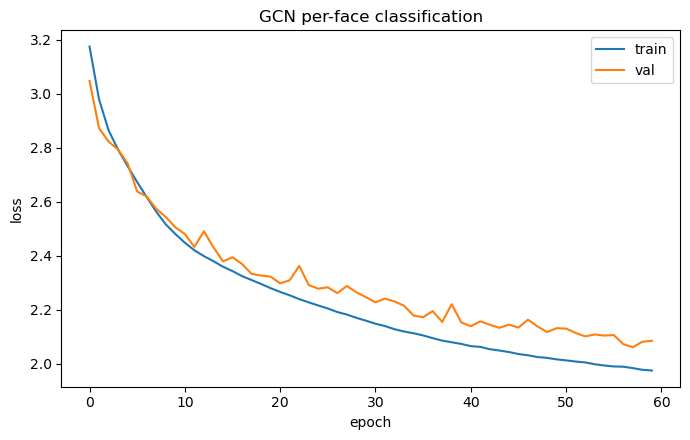


Demo predictions for part 5559:
['stock', 'stock', 'stock', 'stock', 'stock', 'through_hole', 'stock', 'through_hole', 'through_hole', 'through_hole', 'blind_hole', 'blind_hole'] ... (total faces=12)


In [5]:
# gnn_train_infer.py
import os, sys, json, pickle, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import GradScaler
import matplotlib.pyplot as plt

# ---- PyG ----
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

# ========= config =========
ROOT = Path("./dataset/dataset_generation/data")
MAX_ID_SCAN = 10000
NUM_CLASSES = 25  # len(feat_names) below
EPOCHS = 60
HIDDEN = 128
BATCH_SIZE = 64
LR = 3e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 8
SEED = 13

feat_names = ['chamfer', 'through_hole', 'triangular_passage', 'rectangular_passage', '6sides_passage',
              'triangular_through_slot', 'rectangular_through_slot', 'circular_through_slot',
              'rectangular_through_step', '2sides_through_step', 'slanted_through_step', 'Oring', 'blind_hole',
              'triangular_pocket', 'rectangular_pocket', '6sides_pocket', 'circular_end_pocket',
              'rectangular_blind_slot', 'v_circular_end_blind_slot', 'h_circular_end_blind_slot',
              'triangular_blind_step', 'circular_blind_step', 'rectangular_blind_step', 'round', 'stock']

# ---- speed knobs for A40 ----
torch.set_float32_matmul_precision("high")
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

rng = np.random.default_rng(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# ========= data utils (from your dataset_loader, simplified) =========
def get_available_ids(root: Path, max_id=1000):
    root = Path(root)
    have = []
    for i in range(max_id):
        if (root / f"{i}.pkl").exists() and (root / "labels" / f"{i}.json").exists():
            have.append(i)
    return have

def split_ids(ids, seed=13, frac=(0.8, 0.1, 0.1)):
    rng = np.random.default_rng(seed)
    ids = np.array(ids, dtype=int)
    rng.shuffle(ids)
    n = len(ids)
    n_tr = int(frac[0]*n)
    n_va = int(frac[1]*n)
    train = ids[:n_tr].tolist()
    val   = ids[n_tr:n_tr+n_va].tolist()
    test  = ids[n_tr+n_va:].tolist()
    return train, val, test

def _one_hot(idx, n):
    v = np.zeros(n, dtype=np.float32); v[int(idx)] = 1.0; return v

def build_node_features(face_feats: dict, use_type_onehot=False):
    """
    Returns float32 [num_nodes, D] matrix from face_features dict.
    Included: area, adj(deg), loops, centroid(3), convexity(one-hot 3), type(scalar) => D=10
    """
    n = len(face_feats['area'])
    area      = np.asarray(face_feats['area'], dtype=np.float32).reshape(n,1)
    deg       = np.asarray(face_feats['adj'], dtype=np.float32).reshape(n,1)
    loops     = np.asarray(face_feats['loops'], dtype=np.float32).reshape(n,1)
    centroid  = np.asarray(face_feats['centroid'], dtype=np.float32)  # [n,3]
    conv      = np.asarray(face_feats['convexity'], dtype=np.int64)
    conv_oh   = np.stack([_one_hot(c, 3) for c in conv], axis=0)      # [n,3]

    parts = [area, deg, loops, centroid, conv_oh]

    if use_type_onehot:
        stype = np.asarray(face_feats['type'], dtype=np.int64)
        S = int(stype.max()) + 1
        stype_oh = np.stack([_one_hot(t, S) for t in stype], axis=0)
        parts.append(stype_oh)
    else:
        parts.append(np.asarray(face_feats['type'], dtype=np.float32).reshape(n,1))

    x = np.concatenate(parts, axis=1).astype(np.float32)
    # light normalization
    x[:,0] = (x[:,0] - x[:,0].mean()) / (x[:,0].std()+1e-6)  # area z-norm
    x[:,3:6] = x[:,3:6] / (np.linalg.norm(x[:,3:6], axis=1, keepdims=True)+1e-6)  # centroid direction-ish
    return x

def load_sample(root: Path, idx: int):
    root = Path(root)
    pkl_path  = root / f"{idx}.pkl"
    json_path = root / "labels" / f"{idx}.json"
    if not (pkl_path.exists() and json_path.exists()):
        raise FileNotFoundError(idx, pkl_path, json_path)

    with open(pkl_path, "rb") as f:
        G = pickle.load(f)
    with open(json_path, "r") as f:
        J = json.load(f)

    num_nodes = int(G['num_nodes'])
    y = np.array(J['per_face_labels'], dtype=np.int64)
    if len(y) != num_nodes:
        raise ValueError(f"label/face mismatch for {idx}: {len(y)} vs {num_nodes}")

    x = build_node_features(G['face_features'])              # [n, D]
    edge_index = np.asarray(G['edge_index'], dtype=np.int64) # [2, E]

    return {
        "x": torch.from_numpy(x),
        "edge_index": torch.from_numpy(edge_index),
        "y": torch.from_numpy(y),
        "idx": idx
    }

# ========= PyG dataset with lazy cache =========
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, root: Path, ids, cache_mode="lazy", strict=True):
        from tqdm import tqdm
        self.root = Path(root)
        self.ids = []
        self._cache = {} if cache_mode in ("lazy", "all") else None
        self._lazy = (cache_mode == "lazy")

        for i in tqdm(ids, desc="Indexing graphs"):
            try:
                d = load_sample(self.root, i)
                if strict and (d["y"].numel() != d["x"].shape[0]):
                    continue
                self.ids.append(i)
                if cache_mode == "all" or (self._cache is not None and not self._lazy):
                    self._cache[i] = self._to_data(d)
            except Exception:
                continue
        if not self.ids:
            raise RuntimeError("No usable graphs after filtering.")

    @staticmethod
    def _to_data(d):
        return Data(x=d["x"].float(),
                    edge_index=d["edge_index"].long(),
                    y=d["y"].long())

    def __len__(self): return len(self.ids)

    def __getitem__(self, idx):
        pid = self.ids[idx]
        if self._cache is not None and pid in self._cache:
            return self._cache[pid]
        d = load_sample(self.root, pid)
        g = self._to_data(d)
        if self._cache is not None and self._lazy:
            self._cache[pid] = g
        return g

# ========= model =========
class GCN(nn.Module):
    def __init__(self, in_dim, hidden=128, out_dim=NUM_CLASSES, dropout=0.2):
        super().__init__()
        self.c1 = GCNConv(in_dim, hidden)
        self.c2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.c1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.c2(x, edge_index))
        return self.lin(x)

# ========= training helpers =========
def class_weights_from_dataset(ds):
    counts = torch.zeros(NUM_CLASSES, dtype=torch.long)
    for g in ds:
        counts += torch.bincount(g.y, minlength=NUM_CLASSES)
    w = 1.0 / (counts.float() + 1e-6)
    w *= (NUM_CLASSES / w.sum())
    return w

@torch.no_grad()
def evaluate(model, device, loader):
    model.eval()
    total_loss, total_correct, total_labels = 0.0, 0, 0
    for batch in loader:
        batch = batch.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda"), dtype=torch.float16):
            logits = model(batch.x, batch.edge_index)
            loss = F.cross_entropy(logits, batch.y)
        total_loss += float(loss) * batch.y.numel()
        total_correct += (logits.argmax(dim=1) == batch.y).sum().item()
        total_labels += batch.y.numel()
    return total_loss / max(1, total_labels), total_correct / max(1, total_labels)

def train_one_epoch(model, device, loader, opt, scaler, weight):
    model.train()
    total_loss, total_correct, total_labels = 0.0, 0, 0
    for batch in loader:
        batch = batch.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda"), dtype=torch.float16):
            logits = model(batch.x, batch.edge_index)
            w = weight.to(device=device, dtype=logits.dtype) if weight is not None else None
            loss = F.cross_entropy(logits, batch.y, weight=w)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        total_loss += float(loss) * batch.y.numel()
        total_correct += (logits.argmax(dim=1) == batch.y).sum().item()
        total_labels += batch.y.numel()
    return total_loss / max(1, total_labels), total_correct / max(1, total_labels)

# ========= inference utility =========
@torch.no_grad()
def predict_part(model, device, root: Path, part_id: int):
    d = load_sample(root, part_id)
    x = d["x"].to(device)
    ei = d["edge_index"].to(device)
    logits = model(x, ei)
    yhat = logits.argmax(dim=1).cpu().numpy().tolist()
    return [feat_names[i] for i in yhat]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

avail = get_available_ids(ROOT, max_id=MAX_ID_SCAN)
print(f"usable parts on disk: {len(avail)}")
if len(avail) < 50:
    raise RuntimeError("Too few usable samples; generate more.")

ds_tr_ids, ds_va_ids, ds_te_ids = split_ids(avail, seed=SEED)
print(f"split -> train {len(ds_tr_ids)}, val {len(ds_va_ids)}, test {len(ds_te_ids)}")

# build datasets (lazy cache), avoid Windows/Jupyter multiprocessing stalls
IS_WINDOWS = (sys.platform == "win32")
IN_NOTEBOOK = ("ipykernel" in sys.modules)
NUM_WORKERS = 0 if (IS_WINDOWS or IN_NOTEBOOK) else 4
pin = torch.cuda.is_available() and NUM_WORKERS > 0

ds_tr = GraphDataset(ROOT, ds_tr_ids, cache_mode="lazy", strict=True)
ds_va = GraphDataset(ROOT, ds_va_ids, cache_mode="lazy", strict=True)
ds_te = GraphDataset(ROOT, ds_te_ids, cache_mode="none", strict=True)

tr_loader = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,
                        num_workers=NUM_WORKERS, pin_memory=pin)
va_loader = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=pin)
te_loader = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=pin)

# infer feature dimension from one item
g0 = ds_tr[0]
in_dim = g0.x.shape[1]
print(f"in_dim: {in_dim}")

model = GCN(in_dim, hidden=HIDDEN, out_dim=NUM_CLASSES, dropout=0.2).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = GradScaler(enabled=(device.type=="cuda"))
W = class_weights_from_dataset(ds_tr)

# train
hist = {"tr_loss": [], "va_loss": [], "tr_acc": [], "va_acc": []}
best_val, best_state, bad = float("inf"), None, 0

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, device, tr_loader, opt, scaler, W)
    va_loss, va_acc = evaluate(model, device, va_loader)

    hist["tr_loss"].append(tr_loss); hist["va_loss"].append(va_loss)
    hist["tr_acc"].append(tr_acc);   hist["va_acc"].append(va_acc)

    print(f"ep{epoch:03d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= PATIENCE:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state)

# save checkpoint
ckpt_dir = Path("./checkpoints"); ckpt_dir.mkdir(parents=True, exist_ok=True)
ckpt_path = ckpt_dir / "gcn_facecls.pt"
torch.save({
    "state_dict": model.state_dict(),
    "in_dim": in_dim,
    "hidden": HIDDEN,
    "num_classes": NUM_CLASSES,
    "feat_names": feat_names,
    "train_ids": ds_tr.ids, "val_ids": ds_va.ids, "test_ids": ds_te.ids,
}, ckpt_path)
print(f"Saved checkpoint -> {ckpt_path}")

# test
te_loss, te_acc = evaluate(model, device, te_loader)
print(f"TEST  loss/acc: {te_loss:.4f}/{te_acc:.3f}")

# plot
plt.figure(figsize=(7,4.5))
plt.plot(hist["tr_loss"], label="train")
plt.plot(hist["va_loss"], label="val")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.title("GCN per-face classification")
plt.legend(); plt.tight_layout()
plt.show()

# quick demo inference
demo_id = random.choice(ds_te.ids)
pred_names = predict_part(model, device, ROOT, demo_id)
print(f"\nDemo predictions for part {demo_id}:")
print(pred_names[:min(20, len(pred_names))], f"... (total faces={len(pred_names)})")


In [10]:
# quick demo inference
demo_id = random.choice(ds_te.ids)
pred_names = predict_part(model, device, ROOT, demo_id)
print(f"\nDemo predictions for part {demo_id}:")
print(pred_names[:min(20, len(pred_names))], f"... (total faces={len(pred_names)})")


Demo predictions for part 2541:
['triangular_pocket', 'rectangular_pocket', 'round', 'round', 'circular_end_pocket', 'round', 'circular_end_pocket', 'circular_end_pocket', 'circular_end_pocket', 'blind_hole', 'Oring', 'Oring', 'blind_hole'] ... (total faces=13)


In [7]:
# # predict_from_step.py
# from pathlib import Path
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # your pieces
# # from dataset_loader import build_node_features   # uses scalar "type" (D=10)
# from convert_step_to_graph import convert_step_to_graph     # <-- adjust import if named differently

# # label names (used if not embedded in the checkpoint)
# FEAT_NAMES_DEFAULT = ['chamfer', 'through_hole', 'triangular_passage', 'rectangular_passage', '6sides_passage',
#                       'triangular_through_slot', 'rectangular_through_slot', 'circular_through_slot',
#                       'rectangular_through_step', '2sides_through_step', 'slanted_through_step', 'Oring', 'blind_hole',
#                       'triangular_pocket', 'rectangular_pocket', '6sides_pocket', 'circular_end_pocket',
#                       'rectangular_blind_slot', 'v_circular_end_blind_slot', 'h_circular_end_blind_slot',
#                       'triangular_blind_step', 'circular_blind_step', 'rectangular_blind_step', 'round', 'stock']

# NUM_CLASSES = 25

# # same tiny GCN as training
# class GCN(nn.Module):
#     def __init__(self, in_dim, hidden=128, out_dim=NUM_CLASSES, dropout=0.2):
#         super().__init__()
#         from torch_geometric.nn import GCNConv
#         self.c1 = GCNConv(in_dim, hidden)
#         self.c2 = GCNConv(hidden, hidden)
#         self.lin = nn.Linear(hidden, out_dim)
#         self.dropout = dropout
#     def forward(self, x, edge_index):
#         x = F.relu(self.c1(x, edge_index))
#         x = F.dropout(x, p=self.dropout, training=self.training)
#         x = F.relu(self.c2(x, edge_index))
#         return self.lin(x)

# def _load_model(ckpt_path: str | Path, device: torch.device):
#     ckpt = torch.load(ckpt_path, map_location="cpu")
#     in_dim       = int(ckpt.get("in_dim", 10))
#     hidden       = int(ckpt.get("hidden", 128))
#     num_classes  = int(ckpt.get("num_classes", NUM_CLASSES))
#     feat_names   = ckpt.get("feat_names", FEAT_NAMES_DEFAULT)
#     state_dict   = ckpt["state_dict"]

#     model = GCN(in_dim, hidden=hidden, out_dim=num_classes).to(device)
#     model.load_state_dict(state_dict)
#     model.eval()
#     return model, feat_names

# @torch.no_grad()
# def predict_from_step(
#     step_path: str | Path,
#     ckpt_path: str | Path = "./checkpoints/gcn_facecls.pt",
#     device: str | torch.device | None = None,
#     extractor_kwargs: dict | None = None,
#     use_amp: bool = True,
# ):
#     """
#     Returns:
#       {
#         'labels_idx':  [num_faces] int list,
#         'labels_name': [num_faces] str list,
#         'num_faces':   int
#       }
#     """
#     step_path = Path(step_path)
#     if device is None:
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     elif isinstance(device, str):
#         device = torch.device(device)
#     extractor_kwargs = extractor_kwargs or {}

#     # 1) STEP -> graph (we only need face_features + edge_index)
#     # tip: to speed up, you can pass n_samples_proximity=16 or even 0 if you made that safe
#     extractor = BRepGraphExtractor(str(step_path), **extractor_kwargs)
#     graph = extractor.extract_features()

#     # 2) Build node features exactly like training (scalar 'type')
#     x_np = build_node_features(graph["face_features"], use_type_onehot=False)  # shape [N,10]
#     ei_np = np.asarray(graph["edge_index"], dtype=np.int64)                    # shape [2,E]
#     x  = torch.from_numpy(x_np).to(device)
#     ei = torch.from_numpy(ei_np).to(device)

#     # 3) Load model
#     model, feat_names = _load_model(ckpt_path, device)

#     # 4) Predict
#     if device.type == "cuda" and use_amp:
#         with torch.cuda.amp.autocast(dtype=torch.float16):
#             logits = model(x, ei)
#     else:
#         logits = model(x, ei)

#     pred_idx = logits.argmax(dim=1).tolist()
#     pred_names = [feat_names[i] for i in pred_idx]

#     return {"labels_idx": pred_idx, "labels_name": pred_names, "num_faces": len(pred_idx)}

# # --- example ---
# if __name__ == "__main__":
#     res = predict_from_step(
#         step_path="./dataset/dataset_generation/data/0.stp",
#         ckpt_path="./checkpoints/gcn_facecls.pt",
#         device="cuda",
#         extractor_kwargs={"n_samples_proximity": 16},  # faster; not used by the model anyway
#     )
#     print("faces:", res["num_faces"])
#     print(res["labels_name"][:20], "...")
